# T3: Proteomics Integration

### Import necessary packages

In [23]:
import opendvp as dvp
import anndata as ad
import geopandas as gpd
import ast
import spatialdata
import napari_spatialdata
from matplotlib.colors import Normalize
from dask_image import imread

print(f"openDVP version {dvp.__version__}")

openDVP version 0.6.4


## Load adata from DIANN or precious tutorial

for more details of this step go to tutorial 2. 

In [2]:
adata = dvp.io.DIANN_to_adata(
    DIANN_path="../data/proteomics/DIANN_pg_matrix.csv",
    DIANN_sep="\t",
    metadata_path="../data/proteomics/DIANN_metadata.csv",
    metadata_sep=";",
    n_of_protein_metadata_cols=4,
)

16:52:30.85 | INFO | Starting DIANN matrix shape (7030, 14)
16:52:30.85 | INFO | Removing 264 contaminants
16:52:30.86 | INFO | Filtering 3 genes that are NaN
16:52:30.86 | INFO | ['A0A0G2JRQ6_HUMAN', 'A0A0J9YY99_HUMAN', 'YJ005_HUMAN']
16:52:30.88 | INFO | 10 samples, and 6763 proteins
16:52:30.88 | INFO | 52 gene lists (eg 'TMA7;TMA7B') were simplified to ('TMA7').
16:52:30.89 | SUCCESS | Anndata object has been created :) 


If you processed and stored a copy of the adata from tutorial 2, load it here like this

In [3]:
adata = ad.read_h5ad("../data/checkpoints/5_DAP/20250709_1322_5_DAP_adata.h5ad")

## Load shapes of cut samples

## Create spatialdata object

In [4]:
sdata = spatialdata.SpatialData()

SpatialData is a data framework that comprises a FAIR storage format, and a collection of python libraries for performant access, alignment, and processing of uni- and multi-modal spatial omics datasets.  
[Here](https://spatialdata.scverse.org/en/stable/index.html) is its documentation on how to install, use, and extend the core spatialdata library.

Main benefits for Deep Visual Proteomics users:  
1. Standardized data format, enabling use of scverse packages.
2. Store all layers of information into single object, excellent for sharing and replicability.
3. Allows for interative and static visualization of all layers of information.

### Load multiplex immunofluorescence into spatialdata object

This is a "lazy" representation of your image. Meaning, your image data is not being loaded into memory.  
This allows to create spatialdata objects that would be larger than available memory.

In [5]:
# first load as array using dask-image
image_array = imread.imread("../data/image/mIF.ome.tif")
image_array

dask.array<_map_read_frame, shape=(15, 5000, 5000), dtype=uint8, chunksize=(1, 5000, 5000), chunktype=numpy.ndarray>

Here we load in into the spatialdata object we create.  
We use `spatialdata.models.Image2DModel.parse` will ensure that our object is compatible and won't break anything.

In [6]:
# load image to spatialdata object
sdata["mIF"] = spatialdata.models.Image2DModel.parse(image_array)

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


In [7]:
# checking it looks
sdata

SpatialData object
└── Images
      └── 'mIF': DataArray[cyx] (15, 5000, 5000)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images)

### Load proteomics matrix (adata object) to spatialdata object

First we must label the matrix, to let spatialdata know which coordinate system to use.  
In this case, this means labelling which slide it was.

In [8]:
adata.obs["Slide_id"] = "Slide_P12"

In [9]:
adata

AnnData object with n_obs × n_vars = 10 × 4637
    obs: 'Precursors.Identified', 'Proteins.Identified', 'Average.Missed.Tryptic.Cleavages', 'LCMS_run_id', 'RCN', 'RCN_long', 'QuPath_class', 'Slide_id'
    var: 'Protein.Group', 'Protein.Names', 'Genes', 'First.Protein.Description', 'mean', 'nan_proportions', 't_val', 'p_val', 'mean_diff', 'sig', 'p_corr', '-log10_p_corr'
    uns: 'RCN_long_colors', 'filter_features_byNaNs_qc_metrics', 'impute_gaussian_qc_metrics', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'unimputed'

Now we will pass the matrix to spatialdata.  
We need to tell spatialdata what parts of the adata object to use for visualization:
 - `region` is which set of shapes to project these data into, in this case `Slide_P12`.  
 - `region_key` is which column in adata.obs to use for finding the `region` parameter.  
 - `instance_key` refers to the column that links this adata object to the shapes.  

We use `QuPath_class` because that is the column that matches between the adata and the geodataframe.

In [10]:
sdata["proteomics"] = spatialdata.models.TableModel.parse(
    adata=adata, region="Slide_P12", region_key="Slide_id", instance_key="QuPath_class"
)

/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/spatialdata/models/models.py:1144: UserWarning: Converting `region_key: Slide_id` to categorical dtype.
  return convert_region_column_to_categorical(adata)


This step is confusing, maybe checking [Spatialdata documentation](https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/tables.html#table-metadata-annotation-targets) helps, otherwise contact us!

In [11]:
sdata

SpatialData object
├── Images
│     └── 'mIF': DataArray[cyx] (15, 5000, 5000)
└── Tables
      └── 'proteomics': AnnData (10, 4637)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images)

### Load the geodataframe with shapes that match proteomic samples (aka LMD annotations)

In [12]:
gdf = gpd.read_file("../data/proteomics/collection_shapes.geojson")
gdf.head()

id  objectType  \
0  78422794-3ed4-4e09-a9aa-6486c467149d  annotation   
1  70a57ffd-50a0-4449-b873-2dd2a38bf190  annotation   
2  edfda1ca-8de8-44f5-af4e-f16e15bcd4ca  annotation   
3  a0a868c6-c7e3-4fb0-8f4f-071454565080  annotation   
4  ce97d787-321e-4b7d-97e7-55b203fb0373  annotation   

                                      classification  \
0  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
1  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
2  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
3  { "name": "P12_Immune_4", "color": [ 0, 255, 2...   
4  { "name": "P12_Immune_4", "color": [ 0, 255, 2...   

                                            geometry  
0  POLYGON ((3417 955.5, 3417.23 962.94, 3417.93 ...  
1  POLYGON ((3547 715.5, 3547.23 722.94, 3547.93 ...  
2  POLYGON ((3324 568.5, 3324.23 575.94, 3324.93 ...  
3  POLYGON ((4398 2191.5, 4398.21 2198.06, 4398.8...  
4  POLYGON ((4173 2349, 4173.22 2356.16, 4173.9 2...

Here we see that the QuPath class name is inside that classification column.  
Let's get it out

In [13]:
gdf["QuPath_class"] = gdf["classification"].apply(
    lambda row: ast.literal_eval(row).get("name") if isinstance(row, str) else row.get("name")
)

# this line of code says, if classification cells are strings,
# convert to a dictionary and get name attribute,
# otherwise we assume it is already a dictionary and we get the name attribute.

In [14]:
gdf.head()

id  objectType  \
0  78422794-3ed4-4e09-a9aa-6486c467149d  annotation   
1  70a57ffd-50a0-4449-b873-2dd2a38bf190  annotation   
2  edfda1ca-8de8-44f5-af4e-f16e15bcd4ca  annotation   
3  a0a868c6-c7e3-4fb0-8f4f-071454565080  annotation   
4  ce97d787-321e-4b7d-97e7-55b203fb0373  annotation   

                                      classification  \
0  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
1  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
2  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
3  { "name": "P12_Immune_4", "color": [ 0, 255, 2...   
4  { "name": "P12_Immune_4", "color": [ 0, 255, 2...   

                                            geometry  QuPath_class  
0  POLYGON ((3417 955.5, 3417.23 962.94, 3417.93 ...  P12_Immune_3  
1  POLYGON ((3547 715.5, 3547.23 722.94, 3547.93 ...  P12_Immune_3  
2  POLYGON ((3324 568.5, 3324.23 575.94, 3324.93 ...  P12_Immune_3  
3  POLYGON ((4398 2191.5, 4398.21 2198.06, 4398.8...  P12_Immune_4  
4  POLYGON ((4173 2349, 4173.22 2356.16, 4173.9 2...  P12_Immune_4

Now we see that the `QuPath_class` column has our matching names.  
One last thing we must do, is set these names as the index of the geodataframe.

In [15]:
gdf = gdf.set_index("QuPath_class")
gdf.head()

id  objectType  \
QuPath_class                                                     
P12_Immune_3  78422794-3ed4-4e09-a9aa-6486c467149d  annotation   
P12_Immune_3  70a57ffd-50a0-4449-b873-2dd2a38bf190  annotation   
P12_Immune_3  edfda1ca-8de8-44f5-af4e-f16e15bcd4ca  annotation   
P12_Immune_4  a0a868c6-c7e3-4fb0-8f4f-071454565080  annotation   
P12_Immune_4  ce97d787-321e-4b7d-97e7-55b203fb0373  annotation   

                                                 classification  \
QuPath_class                                                      
P12_Immune_3  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
P12_Immune_3  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
P12_Immune_3  { "name": "P12_Immune_3", "color": [ 0, 255, 2...   
P12_Immune_4  { "name": "P12_Immune_4", "color": [ 0, 255, 2...   
P12_Immune_4  { "name": "P12_Immune_4", "color": [ 0, 255, 2...   

                                                       geometry  
QuPath_class                                                     
P12_Immune_3  POLYGON ((3417 955.5, 3417.23 962.94, 3417.93 ...  
P12_Immune_3  POLYGON ((3547 715.5, 3547.23 722.94, 3547.93 ...  
P12_Immune_3  POLYGON ((3324 568.5, 3324.23 575.94, 3324.93 ...  
P12_Immune_4  POLYGON ((4398 2191.5, 4398.21 2198.06, 4398.8...  
P12_Immune_4  POLYGON ((4173 2349, 4173.22 2356.16, 4173.9 2...

Now we see that `QuPath_class` is the index.  
Spatialdata needs this to match the proteomics adata object to these shapes.  
Let's add these prepared shapes to the spatialdata object.

In [16]:
sdata["Slide_P12"] = spatialdata.models.ShapesModel.parse(gdf)

Now we have three pieces of information, all linked and ready to be visualized

In [17]:
sdata

SpatialData object
├── Images
│     └── 'mIF': DataArray[cyx] (15, 5000, 5000)
├── Shapes
│     └── 'Slide_P12': GeoDataFrame shape: (20, 4) (2D shapes)
└── Tables
      └── 'proteomics': AnnData (10, 4637)
with coordinate systems:
    ▸ 'global', with elements:
        mIF (Images), Slide_P12 (Shapes)

### Write spatialdata object for future use

In [19]:
sdata.write("../outputs/spatialdata.zarr")

INFO     The Zarr backing store has been changed from None the new file path: ../outputs/spatialdata.zarr          


In [86]:
sdata = spatialdata.read_zarr("../outputs/spatialdata.zarr")

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/.pixi/envs/spatialdata/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


## Visualize data interactively

This should open a napari instance

In [20]:
napari_spatialdata.Interactive(sdata)

<img src="../_static/spatialdata_example.png" alt="spatialdata_example" width="900px" />

Here you can see the interactive spatialdata viewer.  
We overlay the mIF signal, with any of our proteomic values.  
We can also overlay any value dounf in adata.obs! 

In [21]:
# we need this because of a spatialdata bug, see https://github.com/scverse/spatialdata-plot/issues/475
sdata["Slide_P12"] = sdata["Slide_P12"][~sdata["Slide_P12"].index.duplicated(keep="first")]

/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Slide_P12` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7490196078431373].
/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `Slide_P12` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/jnimoca/Jose_BI/1_Repositories/openDVP/.venv/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `proteomics` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


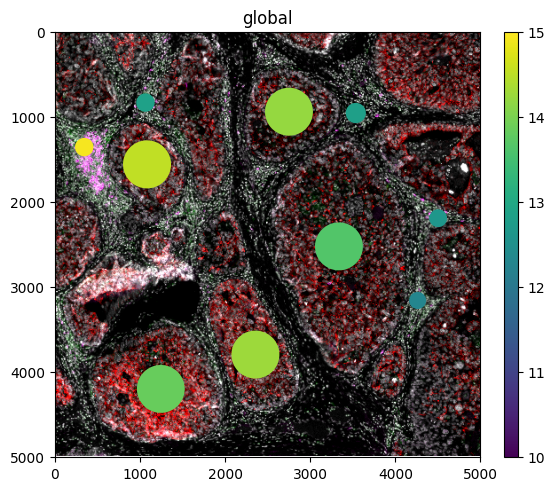

In [24]:
sdata.pl.render_images(
    element="mIF",
    channel=[4, 6, 7, 11],
    norm=Normalize(vmin=3, vmax=75, clip=False),
    palette=["white", "green", "red", "magenta"],
).pl.render_shapes(
    element="Slide_P12",
    table_name="proteomics",
    color="IMPA2",
    cmap="viridis",
    norm=Normalize(vmin=10, vmax=15, clip=False),
).pl.show()